<p style="background-color:#90EE90;color:black;font-size:45px;text-align:center;border-radius:9px 9px;font-weight:bold;border:2px black;">Image Classifier - Men vs Women ~95% Accuracy</p>

In [1]:
# Project Planning --
# 1. The first step for this project is to get a data-set that will serve us well for training the model.
# 2. I've identified 3 good sets that I will download and merge into a large usable set available here:

#    Giant Face Recognition Set - https://www.kaggle.com/datasets/pauliou/giant-face-recognition-set

# This way we can have multiple different styles of faces from different databases to train on.

# 3. We are going to train our model using the Keras Xception Application which has shown remarkably good weights for binary classification.
# 4. We will use Image Augmentation techniques from the ImageDataGenerator keras preprocessing toolset.
# 5. The model will be trained with pre-tuned weights based on my research and from trying different setups until I was satisfied.
# 6. The evaulation will be tested using a sample that is left out of the 3 merged sets.    

In [2]:
import random

import os,sys
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm 


import tensorflow as tf, tensorflow.keras.backend as K
## Bare minimum library requirement

import tensorflow.keras
#Keras provide API for Augmentation helps in generation

import matplotlib.pyplot as plt

In [3]:
#List down all directories in "/kaggle/input/"

source = '../input/giant-face-recognition-set/Data/' #  this is the dataset that I created 

 # defining some dirs
trainDir = source + 'Training/'
testDir = source + 'Testing/'
validDir = source + 'Validation/'
predictionDir = source + 'Unknown/'


print('Directory:',source)
print('Directory:',trainDir)
print('Directory:',testDir)
print('Directory:',validDir)
print('Directory:',predictionDir)


Directory: ../input/giant-face-recognition-set/Data/
Directory: ../input/giant-face-recognition-set/Data/Training/
Directory: ../input/giant-face-recognition-set/Data/Testing/
Directory: ../input/giant-face-recognition-set/Data/Validation/
Directory: ../input/giant-face-recognition-set/Data/Unknown/


In [4]:
batch_size = 10
image_shape = (256,256)

## <p style="background-color:#90EE90;color:black;font-size:30px;text-align:center;border-radius:12px 10px;border:2px;"> 1. Image Extraction and Augmentation </p>

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# here we are going to create the image augmentation parameters for training the model
def image_generator(directory):    
    data_import = ImageDataGenerator(horizontal_flip = True,
                                           width_shift_range = 0.2,
                                           height_shift_range = 0.2,
                                           zoom_range = 0.2,
                                           shear_range = 0.2,
                                           rotation_range = 20,
                                           rescale=1./255,
                                           fill_mode='nearest'
                                      )
    data = data_import.flow_from_directory(directory,
                                          target_size=image_shape,
                                          batch_size=batch_size,
                                          class_mode='binary',
                                          color_mode='rgb',
                                          shuffle=True)
    
    return data

# here we are defining the binary validity test data-sets (separate data)
def valid_generator(directory):
    data_import = ImageDataGenerator(rescale=1./255)

    data = data_import.flow_from_directory(directory,
                                           target_size=image_shape,
                                           batch_size=batch_size,
                                           class_mode='binary',
                                           color_mode='rgb',
                                           shuffle=False)
    return data

In [6]:
# run the image augmentation and extract tool on the three sets of data we will use
train_data = image_generator(trainDir)
test_data = image_generator(testDir)
valid_data = valid_generator(validDir)

Found 242774 images belonging to 2 classes.
Found 20001 images belonging to 2 classes.
Found 34247 images belonging to 2 classes.


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## <p style="background-color:#90EE90;color:black;font-size:30px;text-align:center;border-radius:12px 10px;border:2px;"> 2. Building the Model </p>

In [8]:
pretrained_model = tf.keras.applications.Xception( #  here is the pretrained model that we will be applying to our model
        include_top=False,
        weights= 'imagenet',
        input_shape=(*[256,256],3))

pretrained_model.trainable = True #  we are making the model weights adjustable to see if we can squeeze out some improvement

2022-10-17 16:00:25.695730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 16:00:25.810180: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 16:00:25.811303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 16:00:25.813335: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 0s 0us/step


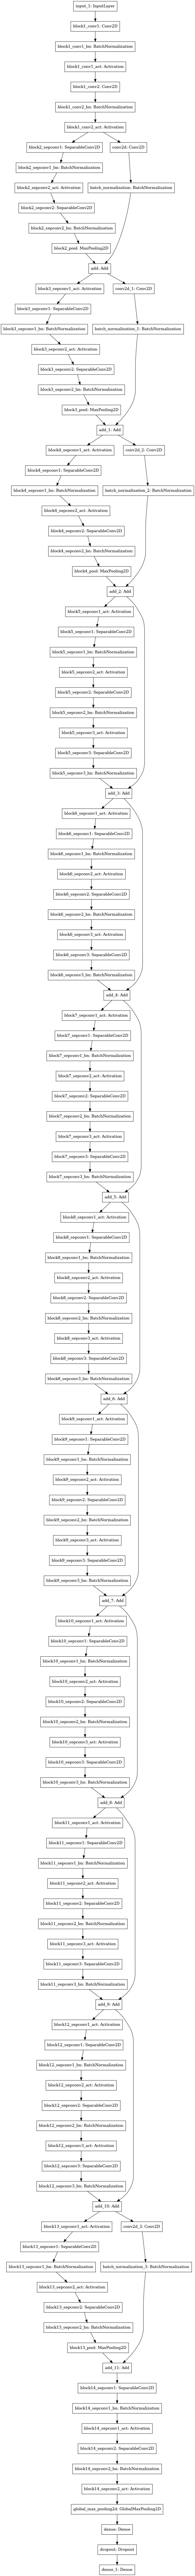

In [9]:
from keras.models import Model
from keras.layers import Flatten, Dense, GlobalMaxPooling2D, Dropout


pretrained_model.trainable = False

last_layer = pretrained_model.get_layer('block14_sepconv2_act')
last_output = last_layer.output
x = BatchNormalization()
x = GlobalMaxPooling2D()(last_output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x) 
x = Dense(1, activation='sigmoid')(x)

model = Model(pretrained_model.input,x)
opt = keras.optimizers.Adagrad(learning_rate=0.001)

#Model compilation
model.compile(
    optimizer= opt,
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

#model summary
tf.keras.utils.plot_model(model)

In [10]:
# here we will define the callback settings for early stopping and saving

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 5, # stops if no min_delta improvement after 5 epochs
    min_delta = 0.01,
    mode = 'auto')
checkpoint_filepath = './'
save_best = tf.keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    monitor = "val_accuracy",
    verbose = 0,
    save_best_only= True,
    mode = "max",
    save_freq = "epoch")

In [11]:
# here we are fitting the model 
epochs = 12
batch_size=64
history = model.fit(train_data,
                steps_per_epoch = 12, # changed these around a fair bit just trying different setups
                epochs = 100,
                validation_data = valid_data,
                validation_steps = len(valid_data)//batch_size,
                callbacks = [early_stopping,save_best])

2022-10-17 16:00:32.660856: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-10-17 16:00:36.309184: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


12/12 [==============================] - 15s 498ms/step - loss: 0.7366 - accuracy: 0.5083 - val_loss: 0.3516 - val_accuracy: 0.9415


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
12/12 [==============================] - 5s 462ms/step - loss: 0.5921 - accuracy: 0.7250 - val_loss: 0.6594 - val_accuracy: 0.6245
Epoch 3/100
12/12 [==============================] - 5s 410ms/step - loss: 0.4646 - accuracy: 0.7667 - val_loss: 0.4675 - val_accuracy: 0.7943
Epoch 4/100
12/12 [==============================] - 5s 404ms/step - loss: 0.4695 - accuracy: 0.7750 - val_loss: 0.3443 - val_accuracy: 0.8925
Epoch 5/100
12/12 [==============================] - 5s 388ms/step - loss: 0.3557 - accuracy: 0.8167 - val_loss: 0.3717 - val_accuracy: 0.8660
Epoch 6/100
12/12 [==============================] - 5s 388ms/step - loss: 0.3023 - accuracy: 0.8500 - val_loss: 0.5903 - val_accuracy: 0.6906


Minimum validation loss: 0.34434348344802856


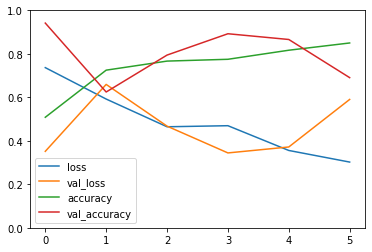

In [12]:
# plotting the loss and accuracy 
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss','accuracy','val_accuracy']].plot()
plt.ylim(0,1)
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

## <p style="background-color:#90EE90;color:black;font-size:30px;text-align:center;border-radius:12px 10px;border:2px;"> 3. Model Results and Evaluation </p>

In [13]:
#testing the model using the evaluate function on unseen data
test_loss, test_acc = history.model.evaluate(test_data, steps=50)
print('test acc:', test_acc)
print('test_loss:',test_loss)

50/50 [==============================] - 10s 205ms/step - loss: 0.2810 - accuracy: 0.8880
test acc: 0.8880000114440918
test_loss: 0.28100520372390747


In [14]:
# here is a fairly poorly written function that at least works, it just gives us a random group of data output

def img_prediction(data,row,col):
    rows=row
    cols =col
    img_count = 0

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))
    plus = random.randint(1,len(data)-16)

    for i in range(rows):
        for j in range(cols):        
            if img_count < 16:
                r_size = cv2.resize(data[img_count+plus][0][0],(256,256))
                roi = cv2.cvtColor(r_size, cv2.COLOR_BGR2RGB)
                finish = roi.reshape(1,256,256,3)
                y_pre = history.model.predict(finish)
                axes[i, j].imshow(data[img_count+plus][0][0])
                x = str('Male' if y_pre > 0.5 else 'Female')
                axes[i, j].set_title(f'Prediction: {x}')
                axes[i, j].axes.get_xaxis().set_visible(False)
                axes[i, j].axes.get_yaxis().set_visible(False)
                img_count+=1
    

## <p style="background-color:#90EE90;color:black;font-size:30px;text-align:center;border-radius:12px 10px;border:2px;"> 4. Model Prediction of Unseen Data</p>

<font size="3" color="black"> This first set of data is based on the same style as the training data. So we are expecting to have pretty good accuracy here. We are currently sitting at around 95% accuracy overall for similary style images!

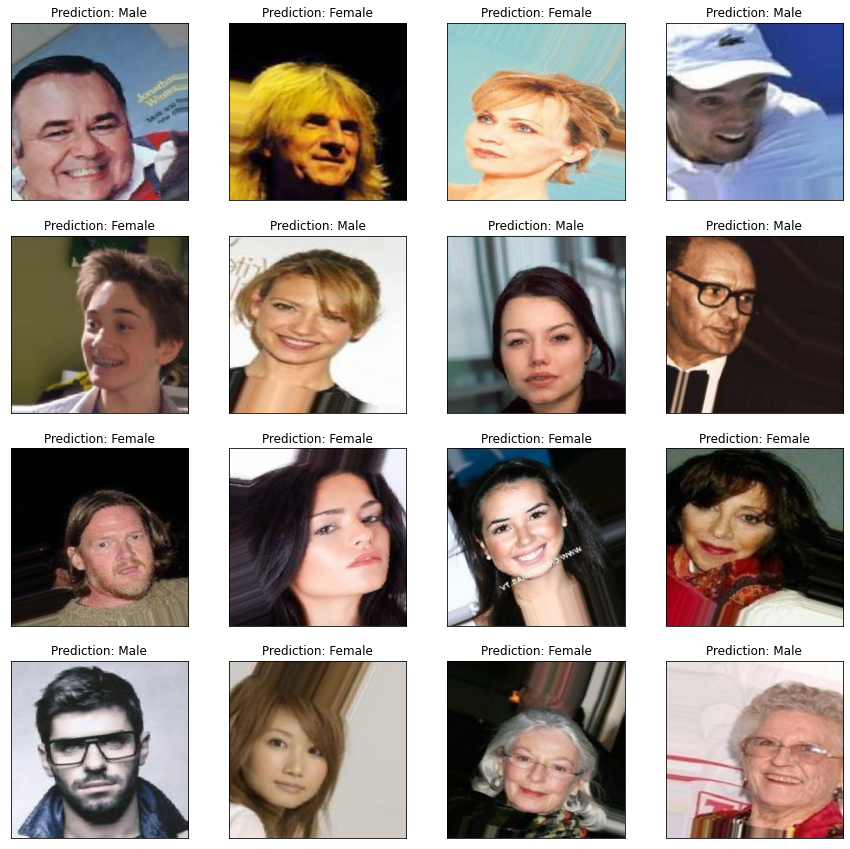

In [15]:
img_prediction(test_data,4,4)

In [16]:
unknown_data = image_generator(predictionDir) # using a further unseen group of data with a fairly different image-style

Found 23709 images belonging to 1 classes.


<font size="3" color="black"> Now we are going to test using some completely unseen and differently styled images. This data-set also includes a huge variety of ages from babies all the way to elderly. So we are not expecting the results to be accurate, but still a fun experiment to see how it might play out in a real world environment!

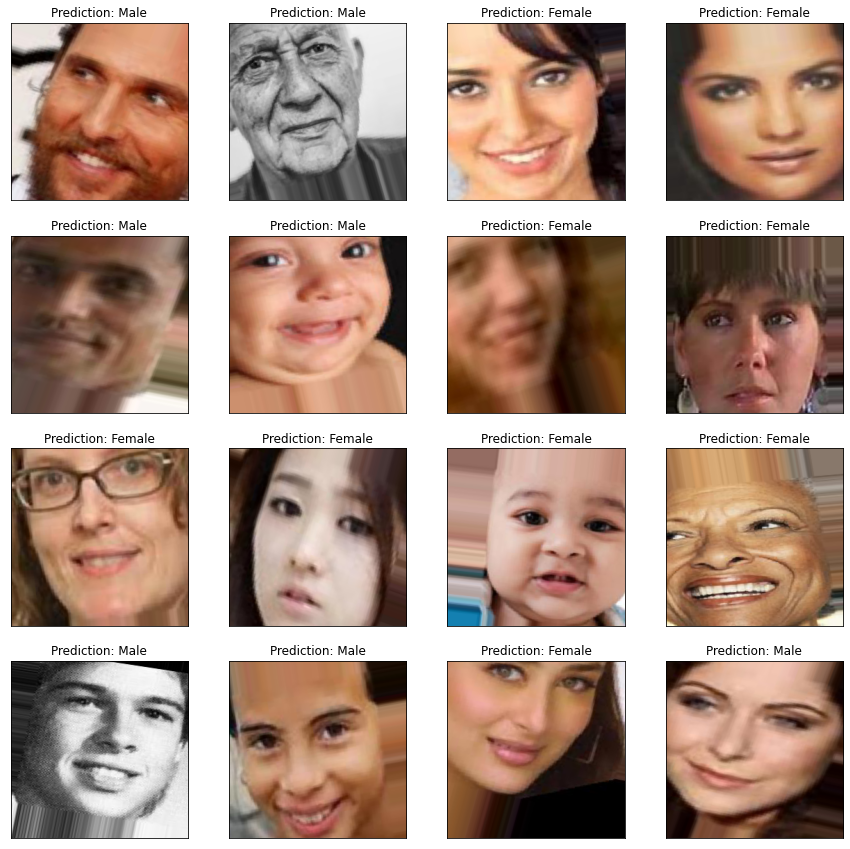

In [17]:
img_prediction(unknown_data,4,4)